### Problem
Dataset is departure data for one of the airports in the USA. Goal is to build model that optimizes two following loss functions using gradient descent and stochastic gradient descent:
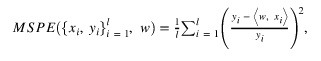

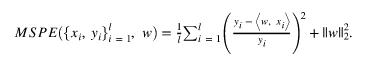

In [72]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import time

### Loading and processing data

In [3]:
flights = pd.read_csv('2008.csv')

flights_clean = flights[~flights.AirTime.isna() ]
flights_clean = flights_clean[flights_clean.columns[~flights_clean.columns.isin(['Cancelled','Diverted', 'CancellationCode', 'TailNum', 'Year', 'ArrDelay'])]]
flights_clean = flights_clean.reset_index(drop = True)

flights.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2008,6,18,3,2111.0,2055,2308.0,2300,WN,242,...,3.0,8.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
1,2008,6,4,3,1426.0,1410,1730.0,1728,XE,2380,...,4.0,12.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
2,2008,8,3,7,1143.0,1145,1501.0,1520,WN,1769,...,4.0,9.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
3,2008,1,23,3,1141.0,1144,1323.0,1335,OO,3802,...,4.0,19.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
4,2008,5,4,7,815.0,820,1243.0,1300,WN,399,...,4.0,8.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN


In [10]:
output = flights_clean['DepDelay']
predictor = flights_clean[flights_clean.columns[~flights_clean.columns.isin(['DepDelay'])]]


### Transforming variables, filling NaN and rescaling

In [11]:
def timefeaturestransformation(df2, columns):
    df = df2.copy()
    for col in columns:
        # first, we convert numeric to int, to get rid of comma and then take two last symbols
        minute = df[col].astype('int32').astype('str').str[-2:]
        hour = df[col].astype('int32').astype('str').str[:-2]
        hour[hour == ''] = 0
        df[col + '_Hour'] = hour.astype('int32')
        df[col + '_Minute'] = minute.astype('int32')
        #df[col + '_Hour'] = df[col + '_Hour'].astype('int32')
    df = df[df.columns[~df.columns.isin(columns)]]
    return(df)

predictor_clean = timefeaturestransformation(predictor, ['DepTime', 'CRSDepTime', 'ArrTime', 'CRSArrTime'])
   

def transform_data(df):
    # filling nan
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    numeric_col = df.select_dtypes(include=numerics).fillna(0)
    categorical_col = df.select_dtypes(exclude=numerics)
    
    # scaling numerical
    scaler = StandardScaler()
    transformed = (scaler.fit_transform(numeric_col))
    numeric_tr = pd.DataFrame(transformed, columns=numeric_col.columns)#.reset_index()
    
    # dummy variable
    categorical_tr = pd.get_dummies(categorical_col, prefix=categorical_col.columns)#.reset_index()
    
    out = pd.concat([numeric_tr, categorical_tr], axis=1)
    return(out)

predictor_transformed = transform_data(predictor_clean) 


### Gradient descent

In [54]:
def make_pred(X, w):
    return(X.dot(w))


def reverse(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w

# calculates mspe error
def mspe(X, y, w):
    y_reverse = reverse(y)
    y_hat = make_pred(X, w)
    return(np.mean(np.multiply((y -y_hat)**2,y_reverse)))

# calcualtes gradient of mspe function
def get_grad(X,  y, w):
    y_reverse = reverse(y)
    X_tr = np.transpose(X)
    y_hat = make_pred(X, w)
    return(X_tr.dot(np.multiply(2*(y_hat - y),y_reverse)))/len(y)

# calculates mspe with regularization
def mspe_reg(X, y, w, alpha):
    return mspe(X,y,w) + alpha*sum(w**2)


# calculates gradient of mspe with regularization
def get_reg_grad(X, y, w, alpha):
    return np.add(get_grad(X,  y, w),2*alpha*w)


# gradient descent algorithm
def grad_descent(X, y, step_size, max_iter, eps,  w0, is_reg, alpha_reg):
    mspe_values = pd.DataFrame()
    w = w0
    mspe_values = mspe_values.append(pd.DataFrame([[0, mspe(X,y,w)]], columns = ['iteration', 'mspe']))
    i = 1
    diff = 1
    #gradient = 1
    #while (np.sqrt(np.sum(gradient**2)) > eps):
    while (diff > eps):
        w_prev = w
        if is_reg == 1:
            gradient = get_reg_grad(X, y, w, alpha_reg)
        else: 
            gradient = get_grad(X, y, w)
        w = w - step_size*gradient
        diff =np.sqrt( np.sum((w - w_prev) ** 2))
        #print("[INFO] iteration #{}, loss={:.7f}".format(i , error))
        mspe_values = mspe_values.append(pd.DataFrame([[i, mspe(X,y,w)]], columns = ['iteration', 'mspe']))
        if (i > max_iter):
            break
        i = i + 1
    
    return  w, mspe_values
    


### Splitting dataset in test and control and initializing parameters

In [70]:
X_train, X_test, y_train, y_test = train_test_split(predictor_transformed, output, test_size=0.3, random_state=42)

X_train.loc[:,'intercept'] = 1
X_test.loc[:,'intercept'] = 1

# initializing coefficients
w0 = np.random.rand(1,X_train.shape[1])[0]


In [79]:
start_time = time.time()

w, mspe_values = grad_descent(X_train[1:1000], y_train[1:1000], step_size = 0.1, 
                              max_iter = 100, eps = 0.0001,  w0 = w0, is_reg = 0, alpha_reg = 0.01)

train_mspe = mspe(X_train[1:1000], y_train[1:1000],w)
test_mspe = mspe(X_test, y_test,w)

print("train mspe %s, test mspe %s, execution time %s seconds"  % (round(train_mspe, 3), round(test_mspe,3), round(time.time() - start_time, 4)) )



train mspe 0.819, test mspe 0.863, execution time 1.2323 seconds


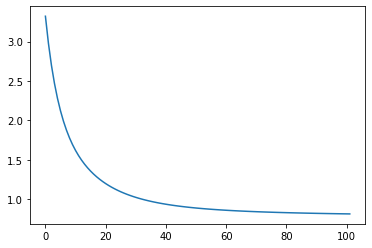

In [68]:
plt.plot(mspe_values.iteration, mspe_values.mspe)

### Gradient descent for function with regularization

2.050599832452834 2.0958158269504654


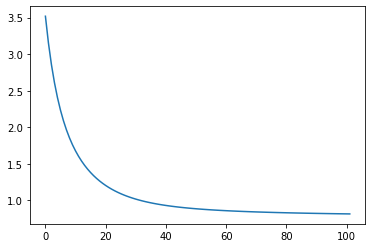

In [61]:
w, mspe_values = grad_descent(X_train[1:1000], y_train[1:1000], step_size = 0.1, 
                              max_iter = 100, eps = 0.0001,  w0 = w0, is_reg = 1, alpha_reg = 0.01)
plt.plot(mspe_values.iteration, mspe_values.mspe)


print(mspe_reg(X_train[1:1000], y_train[1:1000],w,  alpha = 0.01), mspe_reg(X_test, y_test,w, alpha = 0.01))

### Stochastic gradient descent

In [77]:
def sgd(X, y, step_size, max_iter, eps, w0, is_reg, alpha_reg, batch_size):
    mspe_values = pd.DataFrame()
    w = w0
    mspe_values = mspe_values.append(pd.DataFrame([[0, mspe(X,y,w)]], columns = ['iteration', 'mspe']))
    i = 1
    diff = 1
    while (diff > eps):
        w_prev = w
        grad_index = np.random.randint(0,(len(X.index)-batch_size))
        X_ss = X[i:i+batch_size]
        y_ss = y[i:i+batch_size]
        if is_reg == 1:
            gradient = get_reg_grad(X_ss, y_ss, w, alpha_reg)
        else: 
            gradient = get_grad(X_ss, y_ss, w)
        w = w - step_size*gradient
        diff =np.sqrt( np.sum((w - w_prev) ** 2))
        mspe_values = mspe_values.append(pd.DataFrame([[i, mspe(X,y,w)]], columns = ['iteration', 'mspe']))
        #print("[INFO] iteration #{}, loss={:.7f}".format(i , error))
        if (i > max_iter):
            break
        i = i + 1
    
    return  w, mspe_values


In [80]:
start_time = time.time()
w, mspe_values = sgd(X_train[1:1000], y_train[1:1000], step_size = 0.1, 
                              max_iter = 100, eps = 0.0001,  w0 = w0, is_reg = 1, alpha_reg = 0.01, batch_size = 40)

train_mspe = mspe(X_train[1:1000], y_train[1:1000],w)
test_mspe = mspe(X_test, y_test,w)

print("train mspe %s, test mspe %s, execution time %s seconds"  % (round(train_mspe, 3), round(test_mspe,3), round(time.time() - start_time, 4)) )


train mspe 0.925, test mspe 0.935, execution time 0.8797 seconds


Execution is faster for SGD